# Reconstruct Digits with a Variational Autoencoder

In this project I will build a variational autoencoder (VAE) to lean a dense representation of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). Each image in the train dataset will be compressed and reconstructed. This technique can also be used in data generation and anomaly detection.

## Introduction

An autoencoder is consist of two connected networks, an encoder and a decoder. An encoder takes in an input, usually in a high dimension, and converts it into a smaller, dense representation, after which the decoder network converts it into the original dimensional space.

The idea behind variational autoencoders is that instead of mapping an input to a fixed vector/bottleneck, you want to map your input into a distribution, parametrized by mean $\mu$ and variance $\sigma^2$. The only thing different in a VAE is to replace you normal bottleneck $z$ by two separate vectors, one represents the mean and the other one variance. Therefore, whenever you need a vector to feed your decoder network, all you need to do is to take a sample from the distribution.

![title](vae_network.png)

The above graph is borrowed from this [blog](https://www.jeremyjordan.me/variational-autoencoders/), which I found helpful on explaining how a VAE works

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras.metrics import binary_crossentropy
from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.


## Data Preprocessing

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# this is an unsupervised learning problem, so we don't need a test set to train our model
# but we can use it to visulize how each class is represented in the latent space

In [3]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


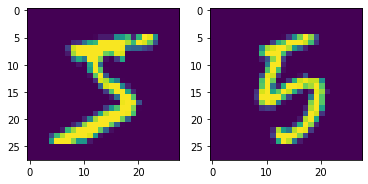

In [4]:
# visualize a couple of instances
plt.figure(1)
plt.subplot(121)
plt.imshow(x_train[0])

plt.subplot(122)
plt.imshow(x_train[690])
plt.show()

In [5]:
# set hyperparameters
IMAGE_SHAPE = (28,28,1)
BATCH_SIZE = 16           

ORIGINAL_DIM = 28 * 28
INTERMEDIATE_DIM = 14 * 14 
LATENT_DIM = 2  # for mean and variance

In [6]:
# reshape and normalize data
x_train = x_train.reshape(-1, ORIGINAL_DIM) / 255. # transform data onto a 0-1 scale
x_test = x_test.reshape(-1, ORIGINAL_DIM) / 255.

In [7]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Model Building

### 1. Encoder network

In [8]:
inputs = Input((ORIGINAL_DIM,), name="encoder_input")
x = Dense(INTERMEDIATE_DIM, activation="relu")(inputs)
z_mu = Dense(LATENT_DIM,  name="z_mean")(x)
z_log_sigma = Dense(LATENT_DIM, name="z_log_sigma")(x)

### 2. Sampling

If the sampled latent vector $z$ is a fixed vector, then we can't do back propagation to train the network, so we use the **reparameterization trick**,

$$
z = \mu + \sigma \otimes \epsilon,
$$

where $\mu$ and $\sigma$ are the learned parameters and $\epsilon \sim N(0,1)$ is the stochastic part

In [9]:
def sampling(args):
    """ Reparameterization trick
    Arguments:
        args (tensor): mean and log of variance of q(z|x)
        
    Return:
        z (tensor): sampled latent vector
    """
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], LATENT_DIM)) # K.random_normal ~ N(0,1) by default
    return z_mu + K.exp(0.5 * z_log_sigma) * epsilon

z = Lambda(sampling, output_shape=(LATENT_DIM,), name="z")([z_mu, z_log_sigma])

### 3. Decoder network

In [10]:
decoder_inputs = Input(shape=(LATENT_DIM,), name="z_samples")
x = Dense(INTERMEDIATE_DIM, activation="relu")(decoder_inputs)
outputs = Dense(ORIGINAL_DIM, activation="sigmoid")(x)
decoder = Model(decoder_inputs, outputs, name="decoder")

In [11]:
z_decoded = decoder(z)

### 4. Loss

VAE requires a unique loss that has two components: the reconstruction loss and the KL divergence

$$
\text{loss} = \lvert\lvert\boldsymbol{x}-d(\boldsymbol{z})\rvert\rvert^2 + \text{KL}\left[N(\mu,\sigma),N(0,1)\right]
$$

The KL divergence term is to make sure the distribution you are learning isn't too far away from the $N(0,1)$.

In [12]:
# construct a custom layer to calculate the loss
class CustomLossLayer(Layer):

    def vae_loss(self, x, z_decoded):
        # Reconstruction loss
        r_loss = binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(r_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLossLayer()([inputs, z_decoded])

In [13]:
# initiate VAE
vae = Model(inputs, y)
vae.compile(optimizer="rmsprop", loss=None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 196)          153860      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            394         dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_sigma (Dense)             (None, 2)            394         dense_1[0][0]                    
____________________________________________________________________________________________

## Model Training

In [14]:
vae.fit(x=x_train, 
        y=None, 
        shuffle=True,
        epochs=20,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 25s 419us/step - loss: 0.2181 - val_loss: 0.2092
Epoch 2/20
60000/60000 [==============================] - 28s 471us/step - loss: 0.2068 - val_loss: 0.2051
Epoch 3/20
60000/60000 [==============================] - 30s 499us/step - loss: 0.2033 - val_loss: 0.2018
Epoch 4/20
60000/60000 [==============================] - 27s 457us/step - loss: 0.2003 - val_loss: 0.1997
Epoch 5/20
60000/60000 [==============================] - 28s 468us/step - loss: 0.1985 - val_loss: 0.1981
Epoch 6/20
60000/60000 [==============================] - 29s 481us/step - loss: 0.1971 - val_loss: 0.1967
Epoch 7/20
60000/60000 [==============================] - 48s 795us/step - loss: 0.1960 - val_loss: 0.1956
Epoch 8/20
60000/60000 [==============================] - 27s 446us/step - loss: 0.1952 - val_loss: 0.1951
Epoch 9/20
60000/60000 [==============================] - 29s 485us/step - loss: 0.1946 - val_

## Results

Let's first compare the reconstructed digits to the real ones.

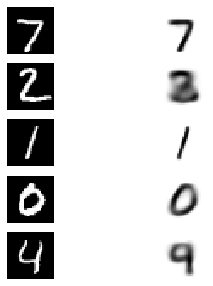

In [15]:
image_size = 28
encoder = Model(inputs, z_mu)

plt.ioff()
plt.figure(figsize=(5, 5))
for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    img = np.reshape(x_test[i], (image_size, image_size))
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')

    plt.subplot(5, 2, 2*i+2)
    encoder_input = np.expand_dims(x_test[i], axis = 0)
    mean = encoder.predict(encoder_input)
    decoded_output = decoder.predict(mean)
    img = np.reshape(x_test[0], (image_size, image_size))
    plt.axis('off')
    plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')

We can also visualize how data are distributed in the 2-dimensional latent space by compressing the test data; note that the original test data are 784-dimensional

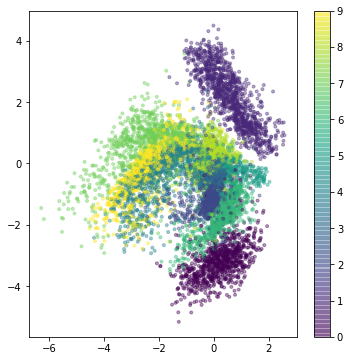

In [16]:
z_test = encoder.predict(x_test, batch_size=BATCH_SIZE)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

Digits have the same class are clustered together!

Now we can look at how the decoded image changes as we change the latent variable

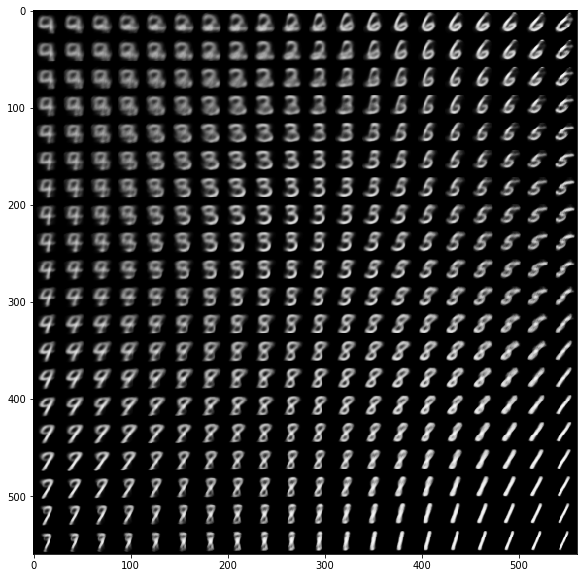

In [17]:
n = 20  
digit_size = 28

# make linearly spaced coordinates 
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n), np.linspace(0.05, 0.95, n)))
# transform the coordinates through the inver CDF (ppf) of the Gaussian 
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
z_grid = norm.ppf(u_grid)

x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()

Digits smoothly transofrm into others as we vary the latent variables